In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa


/home/lenovo/anaconda3/envs/Explan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 定义获取数据的类，确保图像形状为 28*28，并且目标类别为数值形式
# 图像增强方法,形状调整为 28*28
tfm = iaa.Sequential(iaa.Resize(28))
tfm

Sequential(name=UnnamedSequential, random_order=False, children=[Resize(name=UnnamedResize, parameters=[Deterministic(int 28), Deterministic(cubic), HW], deterministic=False)], deterministic=False)

In [3]:
# 定义文件夹作为输入类
class XO(Dataset):
    def __init__(self, folder):  # 遍历该路径下的文件
        self.files = glob(folder)

    def __len__(self): # 返回数据集长度
        return len(self.files)
    
    def __getitem__(self, ix):# 获取索引
        # 返回索引处文件
        f = self.files[ix]
        # 读取文件对图像进行增强
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        # 在图像形状前 创建 通道尺寸
        im = im[None]
        # 根据文件名中的字符 / @ 之间的字符确定图像类别 images/o@123Marker@uPRpUO.png
        cl = f.split('/')[-1].split('@')[0] == 'x'
        # 最后，返回图像及其对应的类别
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

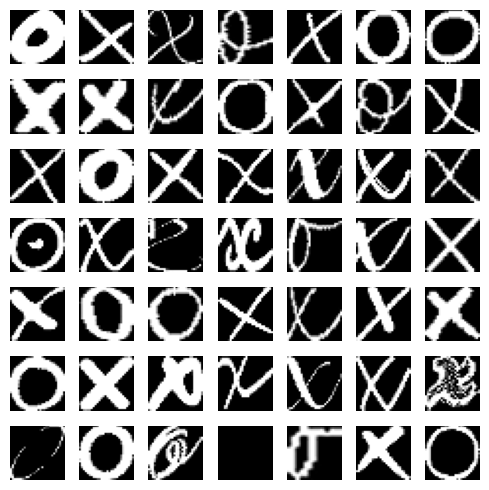

In [4]:
# 由上述定义的类，提取图像及其类别
data = XO('images/*')
# 根据数据集 绘制 图像样本，，两大类 x o
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]  # 图像、类别
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()
plt.show()

In [5]:
# 定义模型架构 损失函数 优化器
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    # 因为是 二分类，所以用交叉熵
    loss_fn = nn.BCELoss()   
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer


In [6]:
from torchsummary import summary #查看模型每层的输出形状，每层的参数数量，总的参数数量，以及模型大小等信息。
model, loss_fn, optimizer = get_model()
"""
summary(model, input_size=(1,28,28))
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
================================================================
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.41
Estimated Total Size (MB): 4.10
"""


'\nsummary(model, input_size=(1,28,28))\n----------------------------------------------------------------\n        Layer (type)               Output Shape         Param #\n================================================================\n            Conv2d-1           [-1, 64, 26, 26]             640\n         MaxPool2d-2           [-1, 64, 13, 13]               0\n              ReLU-3           [-1, 64, 13, 13]               0\n            Conv2d-4          [-1, 128, 11, 11]          73,856\n         MaxPool2d-5            [-1, 128, 5, 5]               0\n              ReLU-6            [-1, 128, 5, 5]               0\n           Flatten-7                 [-1, 3200]               0\n            Linear-8                  [-1, 256]         819,456\n              ReLU-9                  [-1, 256]               0\n           Linear-10                    [-1, 1]             257\n          Sigmoid-11                    [-1, 1]               0\n===============================================

In [7]:
# 定义用于批训练的函数，图像及其类作为输入，并对给定的批数据上执行 反向传播，返回损失与准确率
def train_batch(x, y, model, optimizer, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
# 定义DataLoder
trn_dl = DataLoader(data, batch_size=32, drop_last=True)
# 初始化模型
model, loss_fn, optimizer = get_model()
# 开始训练 10个epoch
for epoch in range(10):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)


tensor([0.], device='cuda:0')
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0706, 0.3137, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.5608, 0.0157, 0.0392, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4745, 1.0000, 1.0000, 0.9882,
         1.0000, 1.0000, 1.0000, 0.9922, 1.0000, 1.0000, 0.4549, 0.0000, 0.0078,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6706, 1.0000, 0.9922, 1.0000, 0.9961,
         1.0000, 1.0000, 1.0000, 1.0000, 0.9922, 1.0000, 0.8078, 0.1216, 0.0000,
         0.3333, 0.5725, 0.5412, 0.5412, 0.5412, 0.5412, 0.5843, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0549, 0.8549, 1.0000, 0.9961, 1.0000, 0.9961, 1.0000,
         0.8353, 0.1294, 0.1686, 0.5686, 1.0000, 0.9961, 1.0000, 0.8824, 0.7255,
         0.9529, 1.0000, 

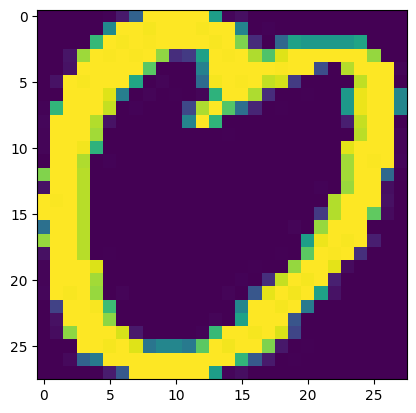

In [13]:
# 获取图像，查看卷积核学到的图像内容
im, c = trn_dl.dataset[2]  # 图像、类别
print(c)
print(im[0].cpu())
plt.imshow(im[0].cpu())
plt.show()


In [40]:
# 将通过训练后的模型，获取其第一层的输出，存在intermediate_output中
print(list(model.children()))
'''
[   Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)), 
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
    ReLU(), 
    Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)), 
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
    ReLU(), 
    Flatten(start_dim=1, end_dim=-1), 
    Linear(in_features=3200, out_features=256, bias=True),  128*5*5
    ReLU(),
    Linear(in_features=256, out_features=1, bias=True), 
    Sigmoid()]

'''
# Sequential( (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)))
first_layer = nn.Sequential(*list(model.children())[:1])
# print(first_layer) 
intermediate_output = first_layer(im[None])[0].detach() # 将一个tensor从计算图中分离，返回新的tensor，但不含梯度信息，无法bp
print(intermediate_output.shape) # torch.Size([64, 26, 26])


[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), ReLU(), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), ReLU(), Flatten(start_dim=1, end_dim=-1), Linear(in_features=3200, out_features=256, bias=True), ReLU(), Linear(in_features=256, out_features=1, bias=True), Sigmoid()]
torch.Size([64, 26, 26])


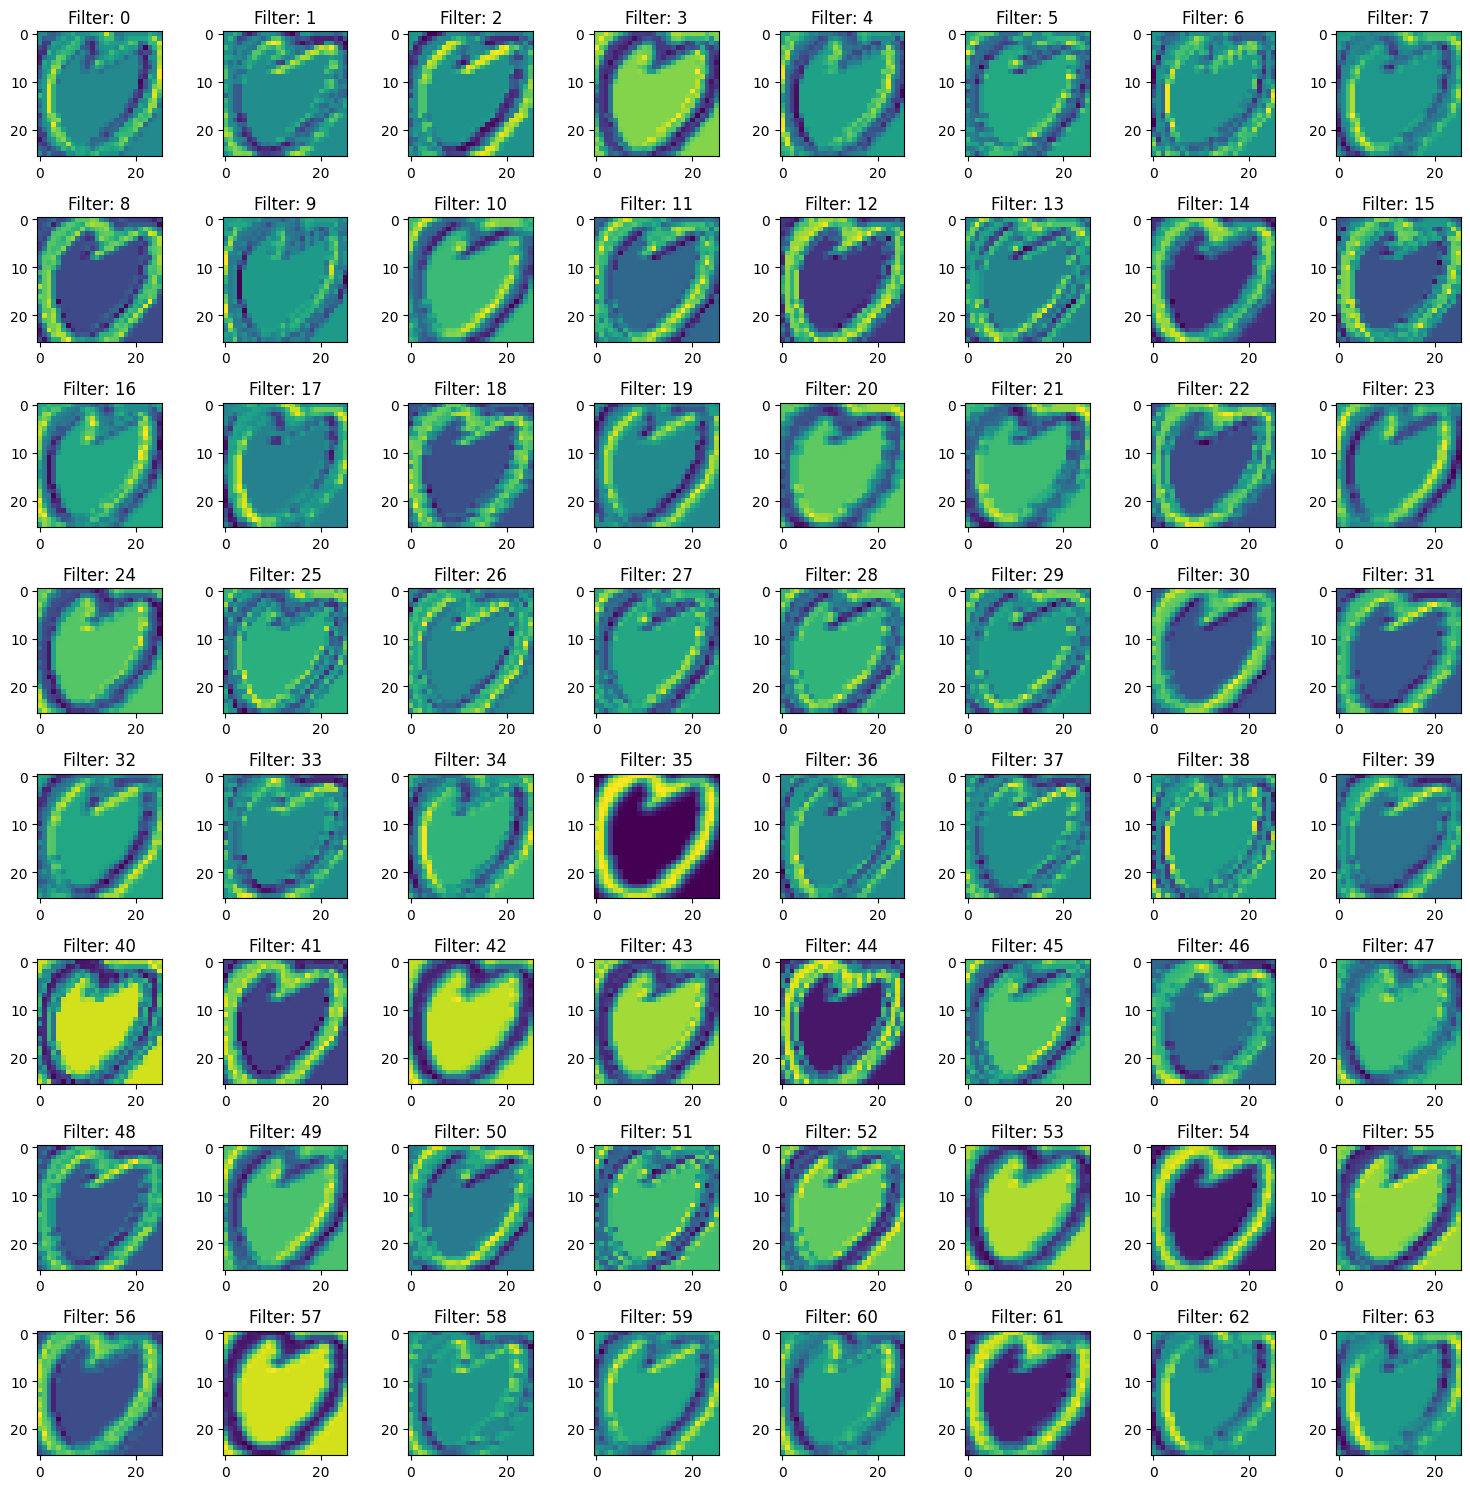

In [19]:
# 绘制64个卷积核（滤波器）的输出,intermediate_output中每个元素对应一个卷积核的卷积输出
n = 8
fig, ax = plt.subplots(n, n, figsize=(15,15))  # 8行8列，图像大小15*15
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()
#####  观察发现 0，4，6，7  学到了图像的边缘

15


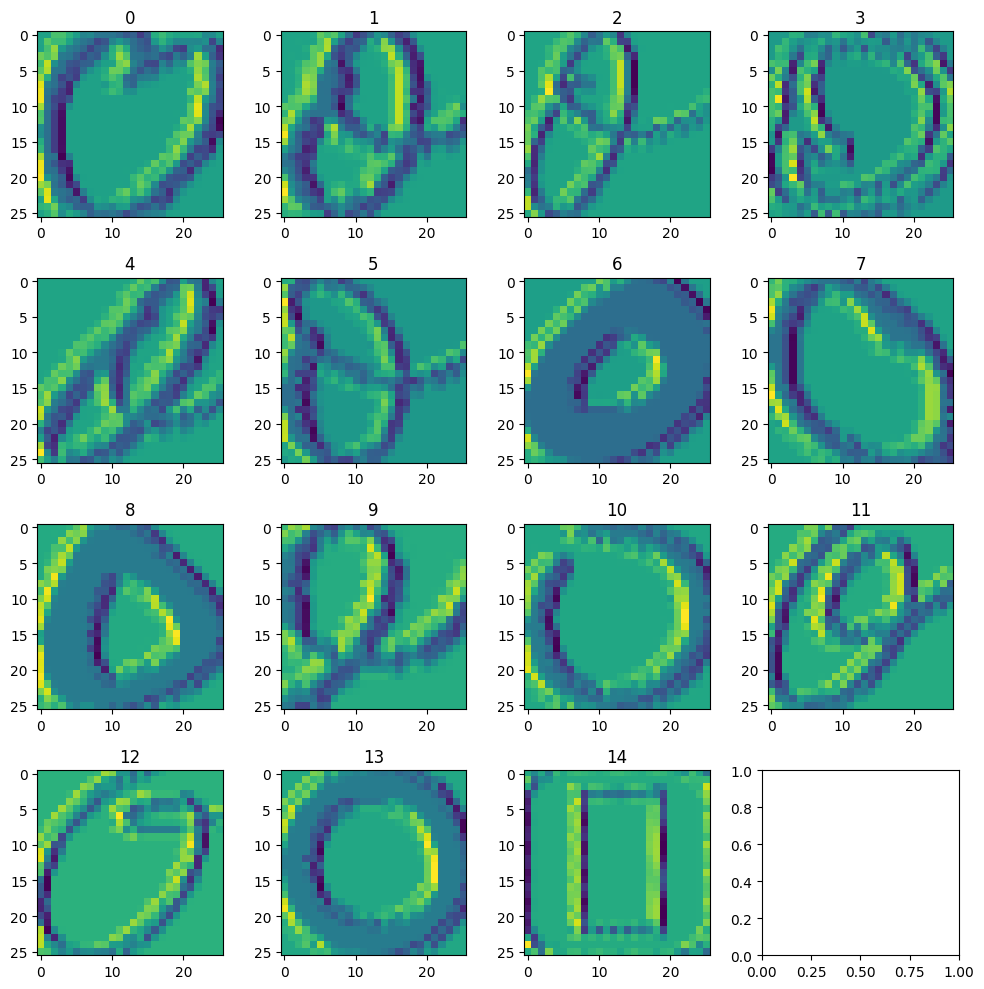

In [20]:
# 输入多个 0 图像，并用第4个卷积核执行卷积显示输出结果 
x, y = next(iter(trn_dl))
x2 = x[y==0]
print(len(x2)) # 15个0图像 

# 调整x2形状作为CNN输入 ,批大小，通道，高度，宽度
x2 = x2.view(-1,1,28,28)

# 定义用于存储模型输出的变量，
first_layer = nn.Sequential(*list(model.children())[:1])
# 提取 0 图像 在第一层后的输出，
# Sequential( (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)))
first_layer_output = first_layer(x2).detach()

# 绘制图像通过第一层后的第4个卷积核的输出
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    if ix < n**2-1:
        axis.imshow(first_layer_output[ix,4,:,:].cpu())
        axis.set_title(str(ix))
plt.tight_layout()
plt.show()


torch.Size([128, 11, 11])


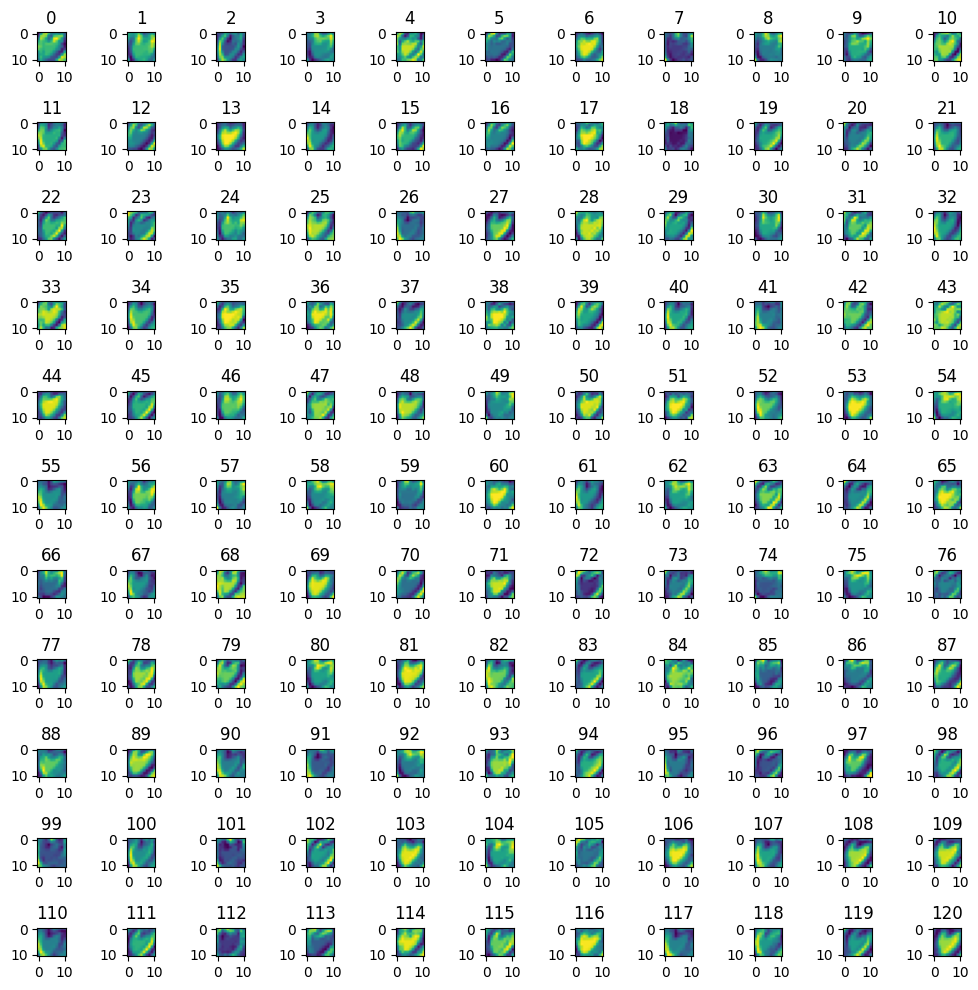

torch.Size([1, 28, 28])


In [21]:
'''
[   Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)), 
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
    ReLU(), 
    Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)), 
]
'''
# 提取 0 图像 从 输入层 到 第2个卷积层 后的输出，
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

print(second_intermediate_output.shape)
# torch.Size([128, 11, 11])

# 绘制图像经过4层后的所有输出，128个
n = 11 #实际只画了121个，
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

print(im.shape)
# torch.Size([1, 28, 28])

torch.Size([1245, 128, 11, 11])


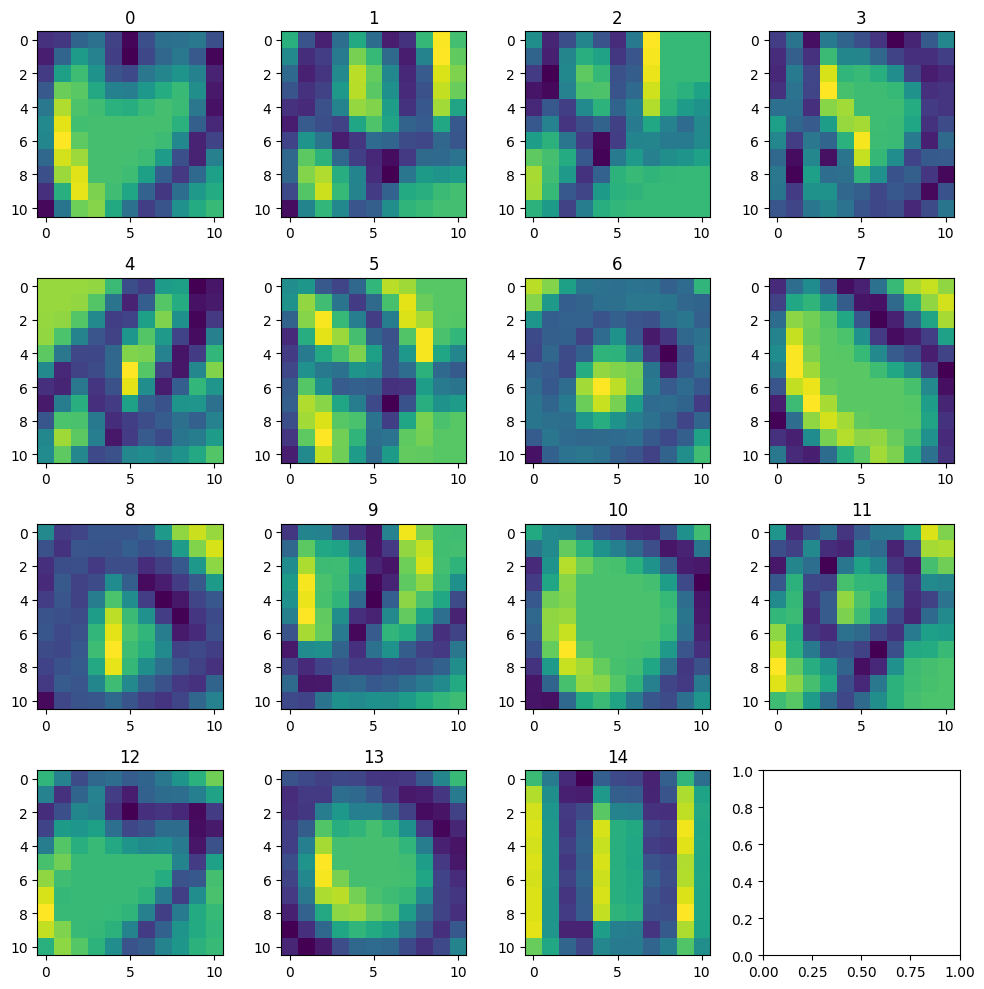

In [24]:
# 当输入多个（15张）0 图像时，看第34个卷积核的输出，可以看到相似的激活
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

print(second_intermediate_output.shape)
# torch.Size([15, 128, 11, 11])
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    if ix < n**2-1:
        axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
        axis.set_title(str(ix))
plt.tight_layout()
plt.show()



2498
1245
torch.Size([1245, 3200])


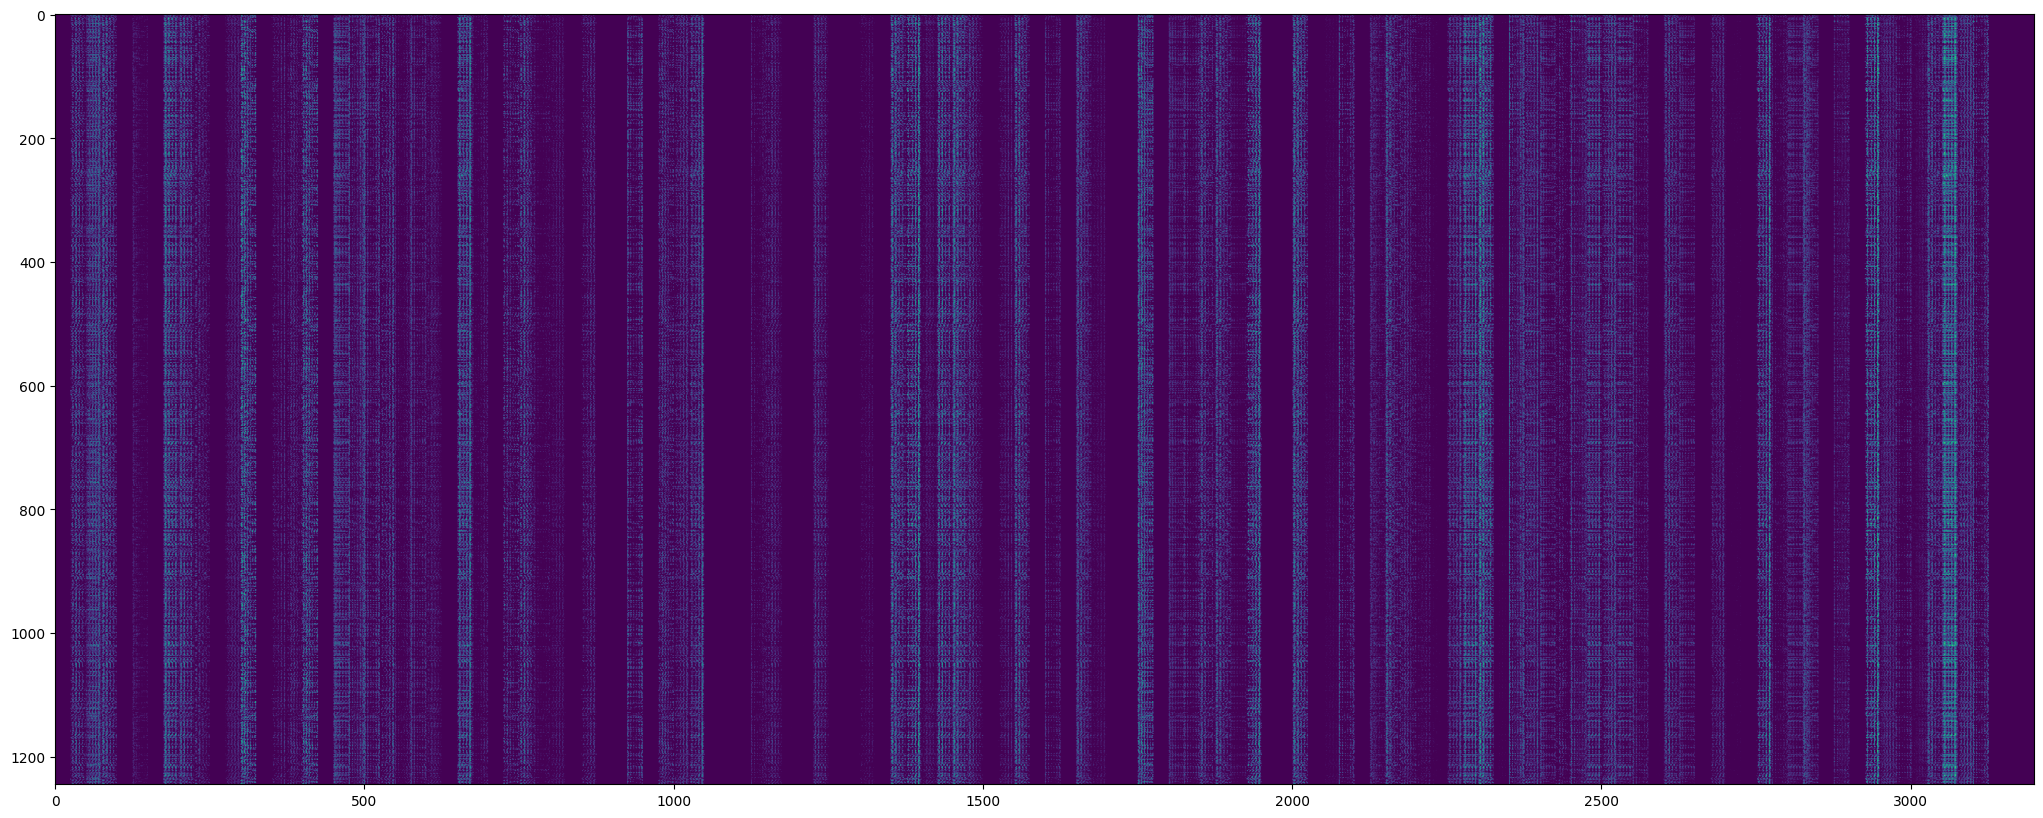

In [41]:
print(len(data))  # 数据集有2498 张

# 绘制全连接层的激活 
# 首先，获取 图像样本 全部输入看的
custom_dl = DataLoader(data, batch_size=2498, drop_last=True)

# 接下来，选择 0 图像，整形28*28后，送入到CNN中
x, y = next(iter(custom_dl))
x2 = x[y==0]
print(len(x2))  # 1245
x2 = x2.view(len(x2),1,28,28)

'''
    Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)), 
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
    ReLU(), 
    Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)), 
    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
    ReLU(), 
    Flatten(start_dim=1, end_dim=-1), 


    Linear(in_features=3200, out_features=256, bias=True), 
    ReLU(),
    Linear(in_features=256, out_features=1, bias=True), 
    Sigmoid()
'''
# 通过CNN模型之后，获取全连接层的输出
flatten_layer = nn.Sequential(*list(model.children())[:7])  # 0-7层的输出
flatten_layer_output = flatten_layer(x2).detach()

print(flatten_layer_output.shape)   # torch.Size([1245, 3200])

# 绘制全连接层的输出
plt.figure(figsize=(100,10))  #宽100，长10的画布
plt.imshow(flatten_layer_output.cpu()) 
plt.show()
# 1245 是因为有 1245张 0 图像，全连接层的输出为3200维，输入为0时，全连接层大于0的激活值会突出，图中显示为白色像素，
### 可以看到，模型已经学习了图像中的结构信息，即使属于同一类的输入图像，其风格也是有较大差异的！！！！